# Model Based Evaluation of RAG applications

In [3]:
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())

### 1. Build a knowledge base

In [4]:
from openai import OpenAI
import weave
from weave import Model
import numpy as np
import json
import asyncio

In [5]:
articles = [
    "Novo Nordisk and Eli Lilly rival soars 32 percent after promising weight loss drug results Shares of Denmarks Zealand Pharma shot 32 percent higher in morning trade, after results showed success in its liver disease treatment survodutide, which is also on trial as a drug to treat obesity. The trial “tells us that the 6mg dose is safe, which is the top dose used in the ongoing [Phase 3] obesity trial too,” one analyst said in a note. The results come amid feverish investor interest in drugs that can be used for weight loss.",
    "Berkshire shares jump after big profit gain as Buffetts conglomerate nears $1 trillion valuation Berkshire Hathaway shares rose on Monday after Warren Buffetts conglomerate posted strong earnings for the fourth quarter over the weekend. Berkshires Class A and B shares jumped more than 1.5%, each. Class A shares are higher by more than 17% this year, while Class B has gained more than 18%. Berkshire was last valued at $930.1 billion, up from $905.5 billion where it closed on Friday, according to FactSet. Berkshire on Saturday posted fourth-quarter operating earnings of $8.481 billion, about 28 percent higher than the $6.625 billion from the year-ago period, driven by big gains in its insurance business. Operating earnings refers to profits from businesses across insurance, railroads and utilities. Meanwhile, Berkshires cash levels also swelled to record levels. The conglomerate held $167.6 billion in cash in the fourth quarter, surpassing the $157.2 billion record the conglomerate held in the prior quarter.",
    "Highmark Health says its combining tech from Google and Epic to give doctors easier access to information Highmark Health announced it is integrating technology from Google Cloud and the health-care software company Epic Systems. The integration aims to make it easier for both payers and providers to access key information they need, even if its stored across multiple points and formats, the company said. Highmark is the parent company of a health plan with 7 million members, a provider network of 14 hospitals and other entities",
    "Rivian and Lucid shares plunge after weak EV earnings reports Shares of electric vehicle makers Rivian and Lucid fell Thursday after the companies reported stagnant production in their fourth-quarter earnings after the bell Wednesday. Rivian shares sank about 25 percent, and Lucids stock dropped around 17 percent. Rivian forecast it will make 57,000 vehicles in 2024, slightly less than the 57,232 vehicles it produced in 2023. Lucid said it expects to make 9,000 vehicles in 2024, more than the 8,428 vehicles it made in 2023.",
    "Mauritius blocks Norwegian cruise ship over fears of a potential cholera outbreak Local authorities on Sunday denied permission for the Norwegian Dawn ship, which has 2,184 passengers and 1,026 crew on board, to access the Mauritius capital of Port Louis, citing “potential health risks.” The Mauritius Ports Authority said Sunday that samples were taken from at least 15 passengers on board the cruise ship. A spokesperson for the U.S.-headquartered Norwegian Cruise Line Holdings said Sunday that 'a small number of guests experienced mild symptoms of a stomach-related illness' during Norwegian Dawns South Africa voyage.",
    "Intuitive Machines lands on the moon in historic first for a U.S. company Intuitive Machines Nova-C cargo lander, named Odysseus after the mythological Greek hero, is the first U.S. spacecraft to soft land on the lunar surface since 1972. Intuitive Machines is the first company to pull off a moon landing — government agencies have carried out all previously successful missions. The company's stock surged in extended trading Thursday, after falling 11 percent in regular trading.",
    "Lunar landing photos: Intuitive Machines Odysseus sends back first images from the moon Intuitive Machines cargo moon lander Odysseus returned its first images from the surface. Company executives believe the lander caught its landing gear sideways on the moon's surface while touching down and tipped over. Despite resting on its side, the company's historic IM-1 mission is still operating on the moon.",
]

def docs_to_embeddings(docs: list) -> list:
    openai = OpenAI()
    document_embeddings = []
    for doc in docs:
        response = (
            openai.embeddings.create(input=doc, model="text-embedding-3-small")
            .data[0]
            .embedding
        )
        document_embeddings.append(response)
    return document_embeddings

article_embeddings = docs_to_embeddings(articles)

### 2. Create a RAG App

In [6]:
from openai import OpenAI
import weave
from weave import Model
import numpy as np
import asyncio

@weave.op()
def get_most_relevant_document(query):
    openai = OpenAI()
    query_embedding = (
        openai.embeddings.create(input=query, model="text-embedding-3-small")
        .data[0]
        .embedding
    )
    similarities = [
        np.dot(query_embedding, doc_emb)
        / (np.linalg.norm(query_embedding) * np.linalg.norm(doc_emb))
        for doc_emb in article_embeddings
    ]
    # Get the index of the most similar document
    most_relevant_doc_index = np.argmax(similarities)
    return articles[most_relevant_doc_index]

class RAGModel(Model):
    system_message: str
    model_name: str = "gpt-3.5-turbo-1106"

    @weave.op()
    def predict(self, question: str) -> dict: # note: `question` will be used later to select data from our evaluation rows
        from openai import OpenAI
        context = get_most_relevant_document(question)
        client = OpenAI()
        query = f"""Use the following information to answer the subsequent question. If the answer cannot be found, write "I don't know."
        Context:
        \"\"\"
        {context}
        \"\"\"
        Question: {question}"""
        response = client.chat.completions.create(
            model=self.model_name,
            messages=[
                {"role": "system", "content": self.system_message},
                {"role": "user", "content": query},
            ],
            temperature=0.0,
            response_format={"type": "text"},
        )
        answer = response.choices[0].message.content
        return {'answer': answer, 'context': context}

weave.init('rag-qa')
model = RAGModel(
    system_message="You are an expert in finance and answer questions related to finance, financial services, and financial markets. When responding based on provided information, be sure to cite the source."
)
model.predict("What significant result was reported about Zealand Pharma's obesity trial?")

Logged in as Weights & Biases user: paul-mriganka.
View Weave data at https://wandb.ai/paul-mriganka-personal/rag-qa/weave
🍩 https://wandb.ai/paul-mriganka-personal/rag-qa/r/call/0196824a-8b97-79f1-8fde-efeb4d1a7022


{'answer': "The significant result reported about Zealand Pharma's obesity trial is that the 6mg dose of its drug survodutide was found to be safe, which is the top dose used in the ongoing Phase 3 obesity trial. This information was reported by an analyst in a note, indicating the safety of the dose used in the trial.",
 'context': 'Novo Nordisk and Eli Lilly rival soars 32 percent after promising weight loss drug results Shares of Denmarks Zealand Pharma shot 32 percent higher in morning trade, after results showed success in its liver disease treatment survodutide, which is also on trial as a drug to treat obesity. The trial “tells us that the 6mg dose is safe, which is the top dose used in the ongoing [Phase 3] obesity trial too,” one analyst said in a note. The results come amid feverish investor interest in drugs that can be used for weight loss.'}

🍩 https://wandb.ai/paul-mriganka-personal/rag-qa/r/call/0196824d-f77b-7e41-bcfa-e64d9e024546


### 3. Evaluating with an LLM as judge

In [7]:
@weave.op()
async def context_precision_score(question, output):
    context_precision_prompt = """Given question, answer and context verify if the context was useful in arriving at the given answer. Give verdict as "1" if useful and "0" if not with json output.
    Output in only valid JSON format.

    question: {question}
    context: {context}
    answer: {answer}
    verdict: """
    client = OpenAI()

    prompt = context_precision_prompt.format(
        question=question,
        context=output['context'],
        answer=output['answer'],
    )

    response = client.chat.completions.create(
        model="gpt-4-turbo-preview",
        messages=[{"role": "user", "content": prompt}],
        response_format={ "type": "json_object" }
    )
    response_message = response.choices[0].message
    response = json.loads(response_message.content)
    return {
        "verdict": int(response["verdict"]) == 1,
    }

questions = [
    {"question": "What significant result was reported about Zealand Pharma's obesity trial?"},
    {"question": "How much did Berkshire Hathaway's cash levels increase in the fourth quarter?"},
    {"question": "What is the goal of Highmark Health's integration of Google Cloud and Epic Systems technology?"},
    {"question": "What were Rivian and Lucid's vehicle production forecasts for 2024?"},
    {"question": "Why was the Norwegian Dawn cruise ship denied access to Mauritius?"},
    {"question": "Which company achieved the first U.S. moon landing since 1972?"},
    {"question": "What issue did Intuitive Machines' lunar lander encounter upon landing on the moon?"}
]
evaluation = weave.Evaluation(dataset=questions, scorers=[context_precision_score])
await evaluation.evaluate(model)

Evaluated 1 of 7 examples

Evaluated 2 of 7 examples

Evaluated 3 of 7 examples

Evaluated 4 of 7 examples

Evaluated 5 of 7 examples

Evaluated 6 of 7 examples

Evaluated 7 of 7 examples

Evaluation summary
{
    'context_precision_score': {'verdict': {'true_count': 7, 'true_fraction': 1.0}},
    'model_latency': {'mean': 5.6567255428859164}
}

{'context_precision_score': {'verdict': {'true_count': 7,
   'true_fraction': 1.0}},
 'model_latency': {'mean': 5.6567255428859164}}

### Evulation output

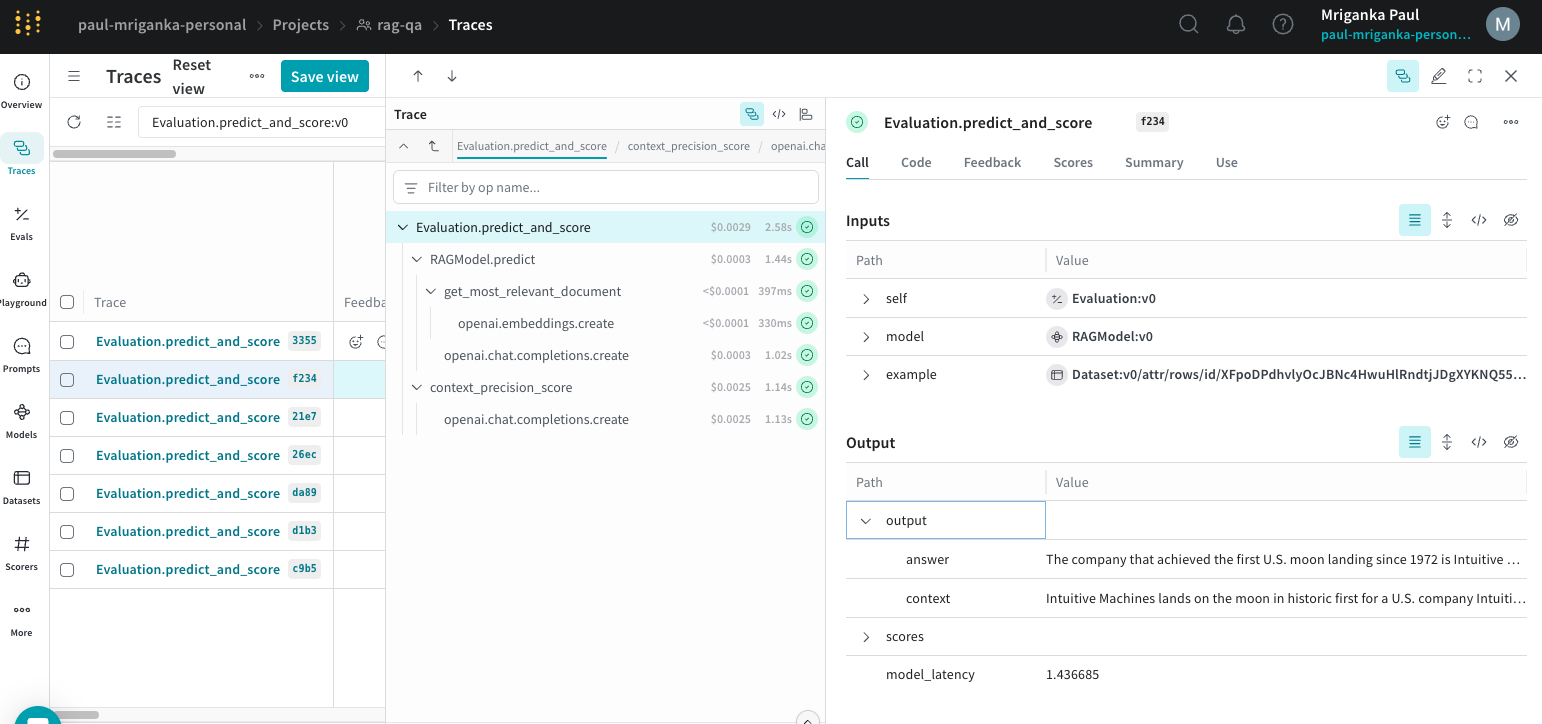